Based on: https://github.com/jdtoscano94/Learning-Scientific_Machine_Learning_Residual_Based_Attention_PINNs_DeepONets/blob/main/Tutorials/PINNs/4_DiffusionEquation.ipynb

Solving:
$$\frac{\partial u}{\partial t} = \frac{\partial u^2}{\partial x} - e^{-t} (\sin(\pi x) - \pi^2 \sin(\pi x))$$
With initial condition
$$y(x, 0) = \sin(\pi x)$$
and boundary conditions
$$y(-1, t) = y(1, t) = 0$$

On the domain $x \in [-1, 1]$ and $t \in [0, 1]$

Explicit solution: $u(x, t) = e^{-t} \sin(\pi x)$

Libraries

In [8]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs
import scipy.io

In [9]:
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Tuning params

In [10]:
steps = 20000
lr = 0.001
layers = np.array([2, 32, 32, 1])

x_min = -1
x_max = 1
t_min = 0
t_max = 1

total_points_x =  200
total_points_t = 100

Nu = 100 # number of boundary points
Nf = 10000 # number of collocation points

Auxiliary plotting functions:

In [11]:
def plot3D(x,t,y):
  x_plot = x.squeeze(1) 
  t_plot = t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [12]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [13]:
# function to approximate
def f_real(x, t):
    return torch.exp(-t) * torch.sin(np.pi * x)

In [14]:
class FCN (nn.Module):

    def __init__(self, layers):
        super().__init__()
        
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.linears = nn.ModuleList([nn.Linear (layers[i], layers[i+1]) for i in range(len(layers)-1)])
                
        # Xavier initialization
        for i in range (len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        
        a = x.float()
        
        # ugly way to make last layer linear
        for layer in self.linears[:-1]:
            z = layer(a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    def loss_BC(self, x, y):
        return self.loss_function(self.forward(x), y)
    
    # here, x is really [x, t]
    def loss_PDE(self, x):
        x_clone = x.clone()
        x_clone.requires_grad = True
        u = self.forward(x_clone)
        u_x_t = autograd.grad(u, x_clone, torch.ones([x_clone.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        u_xx_tt = autograd.grad(u_x_t, x_clone, torch.ones(x_clone.shape).to(device), create_graph=True)[0]

        u_t = u_x_t[:, [1]]
        u_xx = u_xx_tt[:, [0]]

        RHS = u_xx - torch.exp(-x_clone[:, 1:]) * (torch.sin(np.pi * x_clone[:, 0:1]) - np.pi * np.pi * torch.sin(np.pi * x_clone[:, 0:1]))

        return self.loss_function(u_t, RHS)
    
    def loss (self, x_BC, y_BC, x_PDE):
        return self.loss_BC(x_BC, y_BC) + self.loss_PDE(x_PDE)

Generate data

/opt/anaconda3/envs/torch/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_68u_j54pu8/croot/pytorch-select_1717607460029/work/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


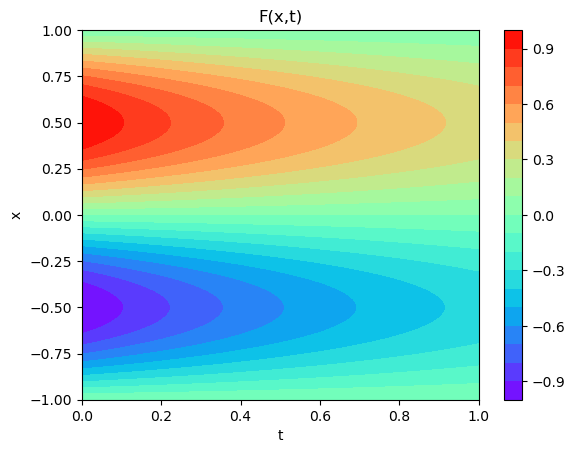

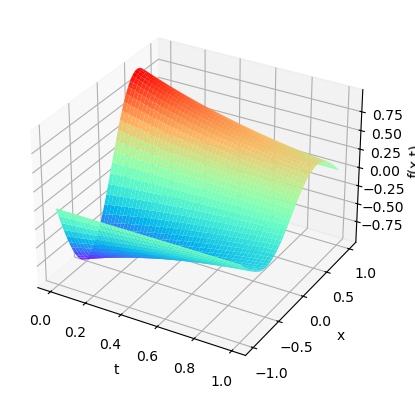

In [15]:
x = torch.linspace (x_min, x_max, total_points_x).view(-1, 1)
t = torch.linspace (t_min, t_max, total_points_t).view(-1, 1)

X, T = torch.meshgrid(x.squeeze(1), t.squeeze(1))

u_real = f_real(X, T)

plot3D(x, t, u_real)

In [16]:
# i do not know how these indices work
x_test = torch.hstack((X.transpose(1, 0).flatten()[:,None], T.transpose(1, 0).flatten()[:,None]))
u_test = u_real.transpose(1, 0).flatten()[:,None]

lb = torch.tensor([x_min, t_min])
ub = torch.tensor([x_max, t_max])

In [17]:
#Initial Condition
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X = torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_U = torch.sin(np.pi*left_X[:,0]).unsqueeze(1)


#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max
bottom_X = torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_U = torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=<t=<1
top_X = torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_U = torch.zeros(top_X.shape[0],1)


#Get all the training data into the same dataset
X_train = torch.vstack([left_X,bottom_X,top_X])
U_train = torch.vstack([left_U,bottom_U,top_U])


#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu = X_train[idx,:]
U_train_Nu = U_train[idx,:]

# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf = lb + (ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf = torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

X_train_Nu = X_train_Nu.float().to(device)
U_train_Nu = U_train_Nu.float().to(device)
X_train_Nf = X_train_Nf.float().to(device)

x_test = x_test.float().to(device)
u_test = u_test.float().to(device)

Defining our NN

In [18]:
model = FCN(layers).to(device)
params = list(model.parameters())
optimizer = optim.Adam(params, lr=lr, amsgrad=False)

In [19]:
start_time = time.time()

for i in range(steps):
    optimizer.zero_grad()
    loss = model.loss(X_train_Nu, U_train_Nu, X_train_Nf)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        with torch.no_grad():
            test_loss = model.loss_BC(x_test, u_test)
        print (f'Step {i}: Training loss {loss.item()} --- Test loss {test_loss.item()}')
        
end_time = time.time()
print (f'Training time: {end_time - start_time}s')

Step 0: Training loss 18.240509033203125 --- Test loss 0.36483609676361084
Step 1000: Training loss 0.008677836507558823 --- Test loss 0.03631982207298279
Step 2000: Training loss 0.0029541817493736744 --- Test loss 0.03963885083794594
Step 3000: Training loss 0.0014216008130460978 --- Test loss 0.03801174461841583
Step 4000: Training loss 0.0007074453169479966 --- Test loss 0.0372793935239315
Step 5000: Training loss 0.00042942221625708044 --- Test loss 0.03694181144237518
Step 6000: Training loss 0.0003320698451716453 --- Test loss 0.03673073276877403
Step 7000: Training loss 0.0002491165651008487 --- Test loss 0.036506813019514084
Step 8000: Training loss 0.0002055181103060022 --- Test loss 0.036393504589796066
Step 9000: Training loss 0.00018092273967340589 --- Test loss 0.03628641739487648
Step 10000: Training loss 0.0003767093294300139 --- Test loss 0.0363226942718029
Step 11000: Training loss 0.0006918095168657601 --- Test loss 0.035979416221380234
Step 12000: Training loss 0.00

Plots!

In [20]:
u_pred = model(x_test).detach().cpu()

x_1 = x_test[:, 0].detach().cpu()
t_1 = x_test[:, 1].detach().cpu()

arr_x1 = x_1.reshape([total_points_t, total_points_x]).transpose(1, 0)
arr_t1 = t_1.reshape([total_points_t, total_points_x]).transpose(1, 0)
arr_u_pred = u_pred.reshape([total_points_t, total_points_x]).transpose(1, 0)

arr_u_test = u_test.reshape([total_points_t, total_points_x]).transpose(1, 0)

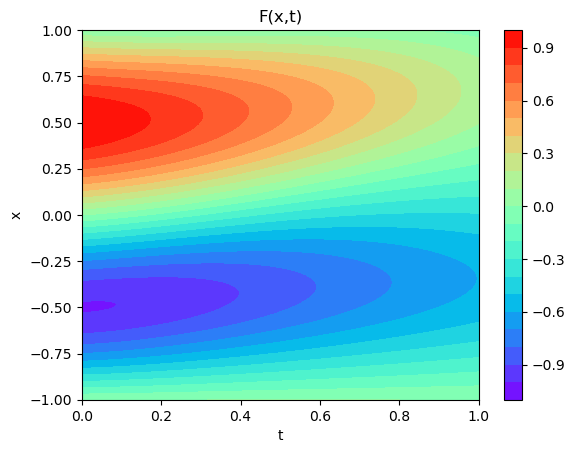

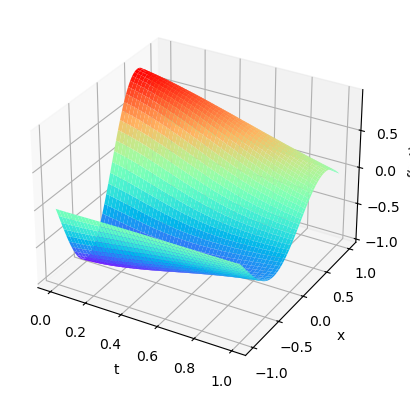

In [21]:
plot3D_Matrix(arr_x1, arr_t1, arr_u_pred)

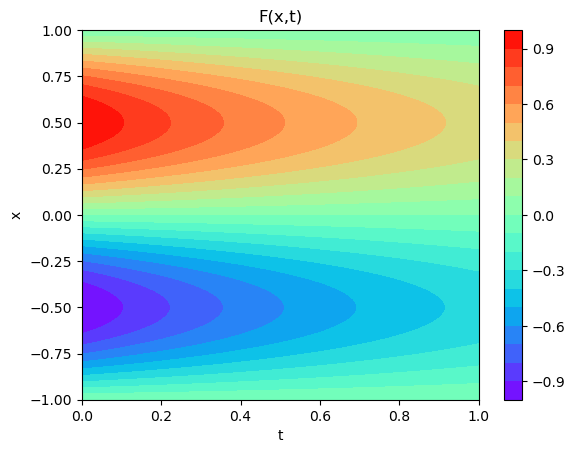

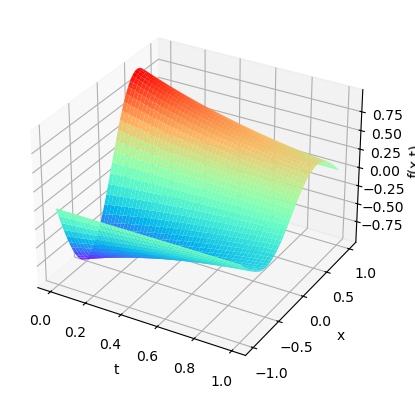

In [22]:
plot3D_Matrix(X, T, u_real)